# Análisis exploratorio de los datos

El primer paso a la hora de trabajar con un conjunto de datos consiste en realizar una exploración para ver la distribución de los datos y si son correctos. En este capítulo realizaremos dicha exploración y veremos si hay que transformar los datos para los algoritmos. 

Lo primero que deberíamos de hacer a continuación es ver de cuántos datos disponemos realmente y la dimensión de las imágenes.

In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Cargamos el dataframe con toda la información necesaria
df = pd.read_csv("../out/dataframe.csv")

In [3]:
df.head()


,patient_id,image_path,class
0,10253,C:\Users\ajf97\Documents\TFG\data\10253\0\1025...,0
1,10253,C:\Users\ajf97\Documents\TFG\data\10253\0\1025...,0
2,10253,C:\Users\ajf97\Documents\TFG\data\10253\0\1025...,0
3,10253,C:\Users\ajf97\Documents\TFG\data\10253\0\1025...,0
4,10253,C:\Users\ajf97\Documents\TFG\data\10253\0\1025...,0


In [4]:
# Contamos el número de pacientes
df.patient_id.value_counts().size

279

In [5]:
# Contamos el número de imágenes disponibles
df.image_path.count()

277524

En la descripción del dataset nos dicen que las imágenes tienen 50x50 píxeles de resolución y 3 canales correspondientes al espacio de color RGB. Veamos si es cierto eligiendo al azar alguna imagen y comprobando sus dimensiones.

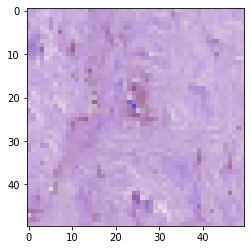

(50, 50, 3)


In [6]:
random_path = df.image_path.sample().iloc[0]
image = cv.imread(random_path)
plt.imshow(image)
plt.show()
print(image.shape)

Ahora vamos a tratar uno de los aspectos más importantes del análisis exploratorio. ¿Existe algún problema de desbalanceo de clases?

In [7]:
# Contamos el número de imágenes de cada clase

df["class"].value_counts()

0    198738
1     78786
Name: class, dtype: int64

A simple vista podemos ver que las clases están **desbalanceadas**. No obstante, vamos a calcular la frecuencia relativa de cada una de las clases.

In [8]:
df["class"].value_counts() / len(df)

0    0.716111
1    0.283889
Name: class, dtype: float64

Vemos que el dataset está muy desbalanceado. El 71,6% de las imágenes no tienen cáncer frente al 28,3% que sí lo tiene. A continuación, dibujamos un histograma para una mejor visualización.

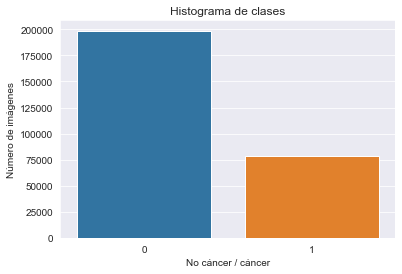

In [9]:
sns.set_style("darkgrid")

sns.countplot(x="class", data=df)
plt.title("Histograma de clases")
plt.xlabel("No cáncer / cáncer")
plt.ylabel("Número de imágenes")
plt.show()

In [10]:
df.groupby("patient_id").size()

patient_id
8863      979
8864     1133
8865      712
8867     1642
8913      955
         ... 
16568     828
16569     337
16570     917
16895     151
16896    1127
Length: 279, dtype: int64

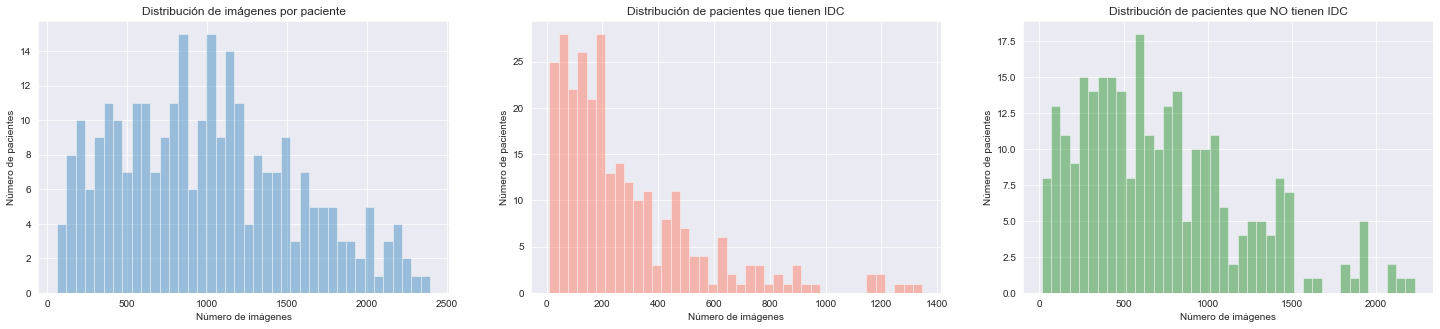

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

idc = df["class"] == 1
non_idc = df["class"] == 0

sns.set_style("darkgrid")
sns.distplot(df.groupby("patient_id").size(), ax=axs[0], bins=40, kde=False)
axs[0].set_title("Distribución de imágenes por paciente")
axs[0].set_xlabel("Número de imágenes")
axs[0].set_ylabel("Número de pacientes")


sns.set_style("darkgrid")
sns.distplot(df[idc].groupby("patient_id").size(), ax=axs[1], color="Tomato", bins=40, kde=False)
axs[1].set_title("Distribución de pacientes que tienen IDC")
axs[1].set_xlabel("Número de imágenes")
axs[1].set_ylabel("Número de pacientes")


sns.set_style("darkgrid")
sns.distplot(df[non_idc].groupby("patient_id").size(), ax=axs[2], color="green", bins=40, kde=False)
axs[2].set_title("Distribución de pacientes que NO tienen IDC")
axs[2].set_xlabel("Número de imágenes")
axs[2].set_ylabel("Número de pacientes")

plt.show()


Observando las gráficas de las distribuciones podemos ver que no son uniformes. La mayoría de pacientes tienen entre 800 y 1200 imágenes mientras que existen muy pocos que tengan más de 2000. Por otro lado, la mayoría de pacientes tienen pocas imágenes de cáncer; otra señal más del desbalanceo.

A continuación, vamos a estudiar si existen diferencias significativas entre las distintas clases de imágenes:

In [19]:
# Seleccionamos al azar 50 imágenes de cada clase
paths_with_idc = np.random.choice(df[idc].image_path.values, 50)
paths_without_idc = np.random.choice(df[non_idc].image_path.values, 50)

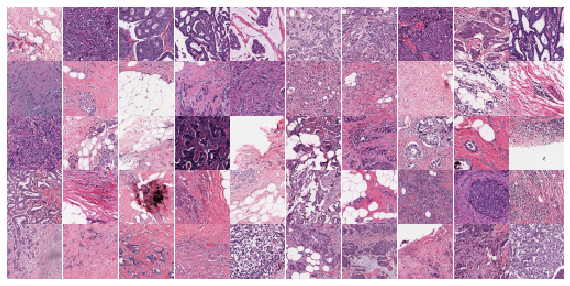

In [22]:
# Mostramos las 50 imágenes con IDC
plt.subplots_adjust(wspace=0, hspace=0)

i = 0

for path in paths_with_idc[:50]:
    image = cv.imread(path)
    image = cv.resize(image, (50,50)) # Reescalamos las imágenes
    plt.subplot(10, 10, i+1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    i += 1

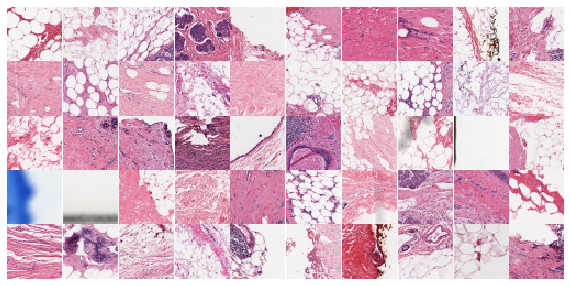

In [23]:
# Mostramos las 50 imágenes sin IDC
plt.subplots_adjust(wspace=0, hspace=0)
i = 0

for path in paths_without_idc[:50]:
    image = cv.imread(path)
    image = cv.resize(image, (50,50)) # Reescalamos las imágenes
    plt.subplot(10, 10, i+1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    i += 1

Podemos apreciar que las imágenes con IDC tienen un color más ocuro. Esto puede ser relevante para el algoritmo de aprendizaje porque puede clasificar como cáncer a las imágenes con píxeles más ocuros.

### Conclusiones

- Algunas imágenes pertenecen a los bordes de la histología. El algoritmo tiene que aprender también a detectar este tipo de zonas de la imagen cuando se pase una nueva como entrada. Por tanto, cuando existan imágenes con una resolución distinta a 50x50 se redimensionarán para que las imágenes sean uniformes

- Los datos están desbalanceados. Para solucionarlo se plantean las siguientes estrategias:
    
    * Submuestreo: Se trata de reducir la muestra de la clase mayoritaria para equilibrar las clases. La desventaja es que se pierde información que puede ser relevante.
    * Sobremuestreo: Aumentamos la clase minoritaria con ejemplos parecidos. No se pierde información pero al tener tantos datos parecidos puede llevar a un sobreajuste
    * Penalización en el error. Algunos algoritmos penalizan más el error cuando se clasifica incorrectamente la clase minoritaria. Con esta forma se trata de reducir el desbalanceo.
    
- No existe el mismo número de imágenes por paciente. Esto puede deberse a la resolución de las histologías originales ya que todas no son del mismo tamaño.

- Existe un problema de memoria al cargar todo el dataset. Dado que usamos arrays multidimensionales de numpy en float32, el conjunto de imágenes completo no cabe en RAM. Soluciones:

    * Submuestreo: al reducir la muestra de la clase mayoritaria se reduce también el número de imágenes en la RAM, pero se pierde información.
    
    * Entrenamiento por lotes: consiste en el cargar poco a poco el dataset en memoria, a medida que se vaya necesitando. Para la librería keras se puede realizar un generador que vaya entrenando la red neuronal poco a poco.